In [1]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
from IPython.display import HTML, display

def display_html(df, index=False):
    display(HTML(df.to_html(index=index)))


In [3]:
'''import kagglehub

# Download latest version
path = kagglehub.dataset_download("parulpandey/emotion-dataset")

print("Path to dataset files:", path)'''

'import kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("parulpandey/emotion-dataset")\n\nprint("Path to dataset files:", path)'

## Exploración del dataset SMILE (Twitter Emotion Classification)

- **Shape**: `(3085, 3)` &nbsp;→ El dataset contiene 3 085 tuits etiquetados manualmente con emociones.  
- **Columnas**: `tweet_id`, `text`, `label`  
- **Origen**: Interacciones en Twitter con museos británicos (2013–2015)

### Distribución de etiquetas

El dataset contiene tanto emociones básicas como etiquetas neutrales o irrelevantes.  
Se listan a continuación las frecuencias de cada una:



In [4]:
import pandas as pd

smile_df = pd.read_csv("smile-annotations-final.csv", encoding="utf-8", header=None, names=["tweet_id", "text", "label"])
print("SMILE shape:", smile_df.shape)
print(smile_df["label"].value_counts())
display_html(smile_df.head())

SMILE shape: (3085, 3)
label
nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: count, dtype: int64


tweet_id,text,label
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from @britishmuseum http://t.co/Q4XSwL0esu) http://t.co/h0evbTBWRq,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with your wish which the artist uses in next installation! It was entralling!,happy
614877582664835073,@Sofabsports thank you for following me back. Great to hear from a diverse &amp; interesting panel #DefeatingDepression @RAMMuseum,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful jewel / portrait. Is the 'R' for Rex ?,happy


## Exploración del dataset *Emotion Recognition Tasks* (Kaggle)

- **Shape**: `(20 000, 2)` &nbsp;→ El corpus unificado contiene 20 000 tuits.
- **Columnas**: `text`, `label`
- **Origen**: Dataset de emociones en Twitter compilado para tareas de reconocimiento de emoción (dividido originalmente en *training*, *validation* y *test*).

### Distribución de etiquetas

Las etiquetas están codificadas con enteros `0‒5`, cada uno representando una emoción distinta:



In [5]:
train_df = pd.read_csv("training.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")
emotion_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

label_col = "sentiment" if "sentiment" in emotion_df.columns else "label"
print("Emotion dataset shape:", emotion_df.shape)
print(emotion_df[label_col].value_counts())
display_html(emotion_df.head())


Emotion dataset shape: (20000, 2)
label
1    6761
0    5797
3    2709
4    2373
2    1641
5     719
Name: count, dtype: int64


text,label
i didnt feel humiliated,0
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,0
im grabbing a minute to post i feel greedy wrong,3
i am ever feeling nostalgic about the fireplace i will know that it is still on the property,2
i am feeling grouchy,3


> **Observaciones**  
> - Las clases **`1`** y **`0`** son las más frecuentes; la clase **`5`** es la menos representada.  
> - Antes de entrenar un modelo, revisar la correspondencia *código → emoción* en la documentación original y considerar técnicas de balance si es necesario.

In [6]:

smile = pd.read_csv("smile-annotations-final.csv", header=None, names=["tweet_id", "text", "label"])
train = pd.read_csv("training.csv")
val   = pd.read_csv("validation.csv")
test  = pd.read_csv("test.csv")
emotion = pd.concat([train, val, test], ignore_index=True)



In [7]:
# SMILE: convertir etiquetas multilabel en binaria
neg = {"angry", "sad", "disgust"}
def smile_to_bin(lbl):
    if any(x in lbl for x in neg):
        return 1
    elif lbl in {"nocode", "not-relevant"}:
        return None  # se descarta
    else:
        return 0

smile["distress"] = smile["label"].apply(smile_to_bin)
smile = smile.dropna(subset=["distress"])
smile = smile[["text", "distress"]]


In [8]:
# Emotion dataset: usar mapeo basado en IDs conocidos
# 0=sadness, 1=joy, 2=love, 3=anger, 4=fear, 5=surprise
distress_codes = {0, 3, 4}  # sadness, anger, fear

emotion["distress"] = emotion["label"].apply(
    lambda x: 1 if x in distress_codes else 0
)


In [9]:
combined = pd.concat([smile, emotion], ignore_index=True)
combined.insert(0, "id", range(len(combined)))


In [10]:
combined.to_csv("tweets_distress_unified.csv", index=False)
combined = combined.drop(columns=["label"])


In [11]:

df = pd.read_csv("tweets_distress_unified.csv")

# 2. Si quedó la columna label con NaN, bórrala
if "label" in df.columns:
    df = df.drop(columns=["label"])

# 3. Asegura que distress sea entero 0/1
df["distress"] = df["distress"].astype("int8")

# 4. Revisa la distribución
print(df["distress"].value_counts())

# 5. Guarda el dataset limpio
df.to_csv("tweets_distress_clean.csv", index=False)
df = pd.read_csv("tweets_distress_clean.csv")


# 1. shape
print("Shape:", df.shape)              # (filas, columnas)

# 2. distribución de la etiqueta binaria
print("\nDistress value_counts():")
print(df["distress"].value_counts())

# 3. primeras filas
display_html(df.head())

# 4. estadísticas básicas de longitud
df["char_len"] = df["text"].str.len()
df["word_len"] = df["text"].str.split().str.len()

stats = df[["char_len", "word_len"]].describe().T
display_html(stats)

# 5. muestra aleatoria de 5 tuits por clase
sample = (df.groupby("distress", group_keys=False)
            .apply(lambda x: x.sample(5, random_state=42))[["distress", "text"]])
display_html(sample)

distress
1    10995
0    10304
Name: count, dtype: int64
Shape: (21299, 3)

Distress value_counts():
distress
1    10995
0    10304
Name: count, dtype: int64


id,text,distress
0,Dorian Gray with Rainbow Scarf #LoveWins (from @britishmuseum http://t.co/Q4XSwL0esu) http://t.co/h0evbTBWRq,0
1,@SelectShowcase @Tate_StIves ... Replace with your wish which the artist uses in next installation! It was entralling!,0
2,@Sofabsports thank you for following me back. Great to hear from a diverse &amp; interesting panel #DefeatingDepression @RAMMuseum,0
3,@britishmuseum @TudorHistory What a beautiful jewel / portrait. Is the 'R' for Rex ?,0
4,@NationalGallery @ThePoldarkian I have always loved this painting.,0


count,mean,std,min,25%,50%,75%,max
21299.0,97.383821,54.724165,7.0,55.0,88.0,130.0,300.0
21299.0,18.827644,10.777477,2.0,11.0,17.0,25.0,66.0


C:\Users\jynsordonez\AppData\Local\Temp\ipykernel_10356\3602391324.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(5, random_state=42))[["distress", "text"]])


distress,text
0,i was definitely feeling nostalgic and was a bit sad when one of my favorite exhibitions the hall of ocean life was closed
0,i said at the beginning i have combination oily skin but i still use this around once a week because my skin feels absolutely gorgeous the morning after applying it
0,i feel as if i am the beloved preparing herself for the wedding
0,i spent some time at the school yesterday talking to folks and snapping pics of my daughters as they delighted in the last day of school fun and i came away feeling impressed and happy which to tell the truth is my usual feeling about the place
0,i feel about politics and i have been very shocked at myself for going into this realm though i think that it is at this time the most important considering everything that has been going on in the world stage and in the usa
1,@JHGHendriks @britishmuseum @aroberts_andrew estimates range from 15000 to 20000 horses killed/severly wounded
1,im feeling so sad that come in later years
1,i always feel a little ashamed of my american history knowledge so i like to learn more when i can
1,i feel that i am too distracted to do well on my weight managment
1,i feel too disillusioned to hope for anything


## Sesgo de los anotadores y su impacto

- **Subjetividad inherente**  
  La clasificación de emociones depende del juicio humano; lo que para un anotador es *nostalgia* (no‑distress), para otro puede sonar claramente *triste* (distress).

- **Contexto cultural y personal**  
  Factores como cultura, idioma, experiencias y estado de ánimo influyen en la percepción emocional.  
  Un mensaje irónico o melancólico puede etiquetarse como positivo si transmite cariño o recuerdos felices.

- **Ejemplo observado**  
  El tuit  
  > *“I was definitely feeling nostalgic and was a bit sad when one of my favorite exhibitions… was closed”*  
  contiene la palabra **“sad”**, pero fue anotado como **love (label 2)** en el corpus original, y por tanto quedó en la clase **no‑distress**.

- **Consecuencia para el modelo**  
  Estos desacuerdos introducen ruido en el entrenamiento y pueden reducir la precisión al generalizar a usuarios con percepciones emocionales diferentes.

- **Mitigación recomendada**  
  1. Revisar manualmente una muestra de casos ambiguos.  -> DIFICIL
  2. Aplicar reglas léxicas o modelos de sentimiento como segunda opinión.   -> viable
  3. Ajustar pesos de clases o usar técnicas robustas a ruido (p. ej. focal loss). -> viable


In [12]:
import torch
print(torch.cuda.is_available())  # Debe ser True
print(torch.cuda.get_device_name(0))  # Nombre de la GPU


True
NVIDIA GeForce RTX 4060


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("tweets_distress_clean.csv")

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["distress"],
    test_size=0.20,
    stratify=df["distress"],
    random_state=42)


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,               # normaliza
        min_df=3,                     # descarta términos raros
        ngram_range=(1,2),            # uni‑ y bi‑gramas
        stop_words="english")),
    ("clf", LogisticRegression(
        class_weight="balanced",      # corrige desbalance
        max_iter=1000,
        solver="liblinear"))
])

pipe_lr.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0      0.952     0.962     0.957      2061
           1      0.964     0.955     0.959      2199

    accuracy                          0.958      4260
   macro avg      0.958     0.958     0.958      4260
weighted avg      0.958     0.958     0.958      4260

[[1982   79]
 [ 100 2099]]


In [16]:
import re

NEG_PAT = re.compile(r"\b(sad|angry|depress|hopeless|suicid|fear|upset|lonely)\b", re.I)

def heuristic_flip(text, pred):
    if pred == 0 and bool(NEG_PAT.search(text)):
        return 1
    return pred

y_pred_heur = [heuristic_flip(t, p) for t, p in zip(X_test, y_pred)]
print(classification_report(y_test, y_pred_heur, digits=3))


              precision    recall  f1-score   support

           0      0.953     0.954     0.954      2061
           1      0.957     0.956     0.957      2199

    accuracy                          0.955      4260
   macro avg      0.955     0.955     0.955      4260
weighted avg      0.955     0.955     0.955      4260



In [ ]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

tok = AutoTokenizer.from_pretrained("vinai/bertweet-base")

train_ds = Dataset.from_pandas(pd.DataFrame({"text": X_train, "labels": y_train.astype(int)}))
test_ds  = Dataset.from_pandas(pd.DataFrame({"text": X_test,  "labels": y_test.astype(int)}))

def tokenize(batch):
    return tok(batch["text"],
               truncation=True,
               padding="max_length",
               max_length=128)

train_ds = train_ds.map(tokenize, batched=True).remove_columns(["text"])
test_ds  = test_ds.map(tokenize,  batched=True).remove_columns(["text"])


model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-base",
    num_labels=2
)


args = TrainingArguments(
    output_dir="bertweet_distress",
    per_device_train_batch_size=32,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    fp16=torch.cuda.is_available()
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
)

trainer.train()


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Map: 100%|██████████| 4260/4260 [00:00<00:00, 5725.83 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.433600
100,0.236400
150,0.167200
200,0.180800
250,0.129800
300,0.116400
350,0.087500
400,0.087500
450,0.099700
500,0.082800


TrainOutput(global_step=1599, training_loss=0.07503977233428669, metrics={'train_runtime': 309.6189, 'train_samples_per_second': 165.096, 'train_steps_per_second': 5.164, 'total_flos': 3362361954209280.0, 'train_loss': 0.07503977233428669, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()
print("\n Resultados de evaluación:")
for k, v in eval_results.items():
    print(f"{k}: {v:.4f}")



📊 Resultados de evaluación:
eval_loss: 0.0550
eval_runtime: 8.2168
eval_samples_per_second: 518.4470
eval_steps_per_second: 64.8670
epoch: 3.0000



📄 Classification Report:
              precision    recall  f1-score   support

           0      0.983     0.982     0.982      2061
           1      0.983     0.984     0.983      2199

    accuracy                          0.983      4260
   macro avg      0.983     0.983     0.983      4260
weighted avg      0.983     0.983     0.983      4260



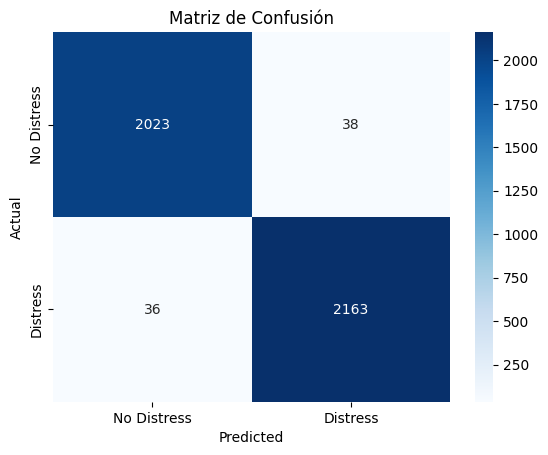

In [ ]:
preds = trainer.predict(test_ds)
y_pred = preds.predictions.argmax(axis=1)
y_true = y_test 

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n Classification Report:")
print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Distress", "Distress"], yticklabels=["No Distress", "Distress"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()
